# Explain XGBoost Model Using SHAP

SHapley Additive exPlanations (SHAP) can be used to fairly distribute contributions from input features to the predicted outcome (e.g., will a customer churn?). Shapley values can also be used as a normalization which scales the feature columns into the same units as the prediction. This may help in certain clustering tasks (e.g., identify similar features, perform customer segmentation, etc.). Additional details can be found at: https://shap.readthedocs.io/. 

Before deploying models into production, it may be a good idea to perform sanity checks to validate model predictions and provide additional insights for further investigation. This notebook highlights some of the methods that can be applied to help validate and explain model predictions using SHAP values. Explainable ML techniques become computationally expensive when performed across large datasets. Typically, local explanations are sought when dealing with complex data models. 

In [1]:
import os
import sys
import re
import json
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from time import time
from functools import reduce
import matplotlib.pyplot as plt

import dask
import dask.dataframe as dd
import dask.bag as db
from dask.distributed import Client, progress
from datetime import datetime

import shap
import sklearn
import xgboost as xgb

# Modify "run_type" to change the hardware used to run the computations. 
# Note that a model file for the same "run_type" needs to be available. A model produced by CPU-training may differ from another produced during GPU-training.
run_type = 'gpu'
enc_output_dir = './enc_data/train'

# Sampling fraction of data within enc_output_dir to simulate other scale factors
sample_frac = 1 # Use smaller fraction such as 0.1 for large scale factors.

if run_type == 'gpu':
    from dask_cuda import LocalCUDACluster

    # Use LocalCUDACluster for multi-GPU on the same node:
    cuda_cluster = LocalCUDACluster(n_workers=1, threads_per_worker=8) # p3.2xlarge has 1x V100, 8 vCPU
    # cuda_cluster = LocalCUDACluster(n_workers=2, threads_per_worker=8) # p3.8xlarge has 4x V100, 32 vCPU
    client = Client(cuda_cluster) # Single node, multi-GPU possible with LocalCUDACluster
    
    # Single GPU, local run:
    # client = Client(n_workers=1, threads_per_worker=8) # Single GPU local cluster
    # client = Client('tcp://127.0.0.1:8786') # Externally managed cluster
else:
    # Local CPU-only run:
    # client = Client(n_workers=1, threads_per_worker=32) # Specify number of CPU cores to use
    client = Client(n_workers=1) # Use all CPU cores

client

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34419 instead
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: LocalCUDACluster
Dashboard: http://127.0.0.1:34419/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:34419/status,Workers: 1
Total threads: 8,Total memory: 251.65 GiB
Comm: tcp://127.0.0.1:43759,Workers: 1
Dashboard: http://127.0.0.1:34419/status,Total threads: 8
Started: Just now,Total memory: 251.65 GiB
Comm: tcp://127.0.0.1:37221,Total threads: 8
Dashboard: http://127.0.0.1:40711/status,Memory: 251.65 GiB
Nanny: tcp://127.0.0.1:33381,


# Load Model and Compute SHAP Values

In [2]:
if run_type == 'gpu':
    import dask_cudf as hw
    import cupy as cp
else:
    import dask.dataframe as hw
    
# Run predictions:
method = 'xgb_' + run_type
data_path = enc_output_dir
label_col = 'Churn'
model_file = 'python_telco_dask_xgb_'+run_type+'.model' # xgboost model file generated previously
model = xgb.Booster(model_file=model_file)
model.set_param('predictor', run_type+'_predictor')


tic = time()
# SHAP is built into xgboost 1.3+!
if (method == 'xgb_gpu') | (method == 'xgb_cpu'):
    method_type = method.split('_')[1]
    
    # Load data:
#     ddf_enc = hw.read_parquet(data_path).persist()
    ddf_enc = hw.read_parquet(data_path).sample(frac=sample_frac).reset_index(drop=True).persist() # Sample small subset of data
#     print('Number of resampled records:', len(ddf_enc))
    
    # Format data for xgboost training:
    feature_cols = [cc for cc in ddf_enc.columns if cc not in [label_col, 'cv_idx']]
#     print(feature_cols)
    
    X = ddf_enc[feature_cols].astype('float32')
    y = ddf_enc[label_col].astype('float32')

    # See https://xgboost.readthedocs.io/en/latest/tutorials/dask.html#running-prediction.
    shap_values = xgb.dask.predict(client, model, xgb.dask.DaskDMatrix(client, X, y), pred_contribs=True) # For SHAP value computation, using xgb.dask.DaskDMatrix() is faster than X.
#     shap_values = xgb.dask.inplace_predict(client, model, X) # Use inplace_predict() can sometimes be faster, but cannot be used with pred_contribs=True for SHAP computation.

# Compute Shapley value using dask+xgb shap API:
shap_values = shap_values.compute()
shap_expected_values = shap_values[:,-1]
shap_values = shap_values[:,:-1]

# Note that Dask+XGB has an extra column appended. "The last column in the output shap_values contains the ‘bias’ or the expected output of the model if no features were used."
# Since we will be using the python shap package to visualize results, it's safe to drop the last column for compatibility.
# pred_contribs (bool) – When this is True the output will be a matrix of size (nsample, nfeats + 1) with each record indicating the feature contributions (SHAP values) for that prediction. 
# The sum of all feature contributions is equal to the raw untransformed margin value of the prediction. Note that the final column is the bias term.
print('Dask + xgboost internal shap_values shape:', np.shape(shap_values))
print('Dask + xgboost shap_values computation time:', '{:0.2f}'.format(time() - tic) + 's')

Dask + xgboost internal shap_values shape: (562500, 40)
Dask + xgboost shap_values computation time: 23.65s


In [3]:
# Transform data types for compatibility:

# shap package only understands pandas dataframe. Convert various representations into pandas.
if run_type == 'gpu':
    # Need to convert dask_cudf to pandas:
    pd_enc = ddf_enc.compute().to_pandas()
    X_cmp = X.compute().to_pandas() # Gather dask_cudf and then convert to single pandas dataframe.
    y_cmp = y.compute().to_pandas()
else:
    pd_enc = ddf_enc.compute()
    X_cmp = X.compute() # Gather ddf into pandas
    y_cmp = y.compute()
    
# Need to input externally computed SHAP values into shap.TreeExplainer object to use plotting APIs.
explainer = shap.TreeExplainer(model, X_cmp)
shap_obj = explainer(X_cmp.iloc[:5]) # Compute for dummy data

# Overwrite SHAP values within Explainer object:
shap_obj.data = X_cmp.values
shap_obj.values = shap_values
shap_obj.base_values = shap_expected_values

# Applications of SHAP Value
With SHAP values computed, we can examine how much each input feature contributes to individual predicted outcomes. By default for binary classification problems, SHAP values are represented in log-odds space. The "force plot" below allows us to visualize contributing factors to the predicted outcome for each customer record (i.e., row of data). Positive log-odds factors (indicated by the red chevrons) push the predicted outcome to the right while negative log-odds factors push in the opposite direction. The total contribution is obtained by summing the SHAP values as indicated by the bold black number. A negative total contribution corresponds to a probability of less than 50% (or no churn). 

In [4]:
# load JS visualization code to notebook
shap.initjs()

# Examine explanation for a single observation:
row_num = 10
shap.force_plot(shap_expected_values[row_num], shap_values[row_num,:], X_cmp.iloc[row_num,:]) # Shap values from dask + xgb package

## Feature Importance

To determine global feature importance, the average impact of SHAP values can be computed across all samples as shown below. Permutation importance is considered in the SHAP formulation so it provides a better representation than conventional measures of feature importance. Global feature importance allows us to drop certain features that are not as important to the overall prediction.

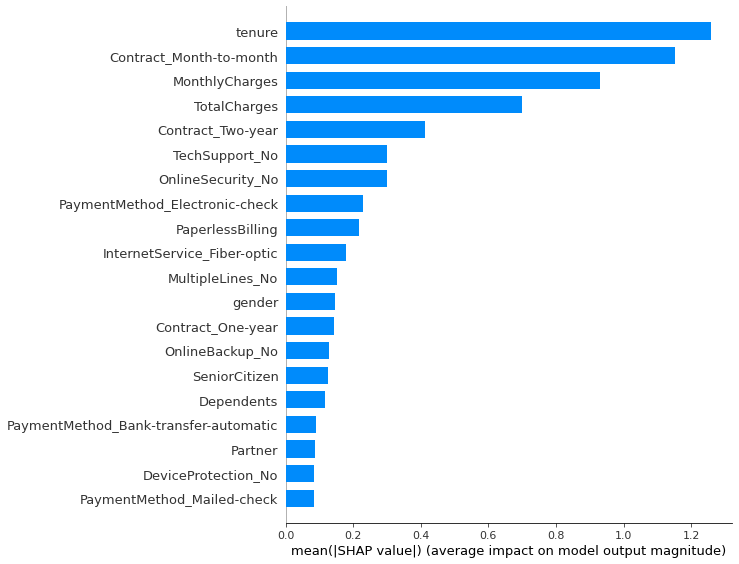

In [5]:
shap.summary_plot(shap_obj, plot_type='bar')

The results can be further broken down by cohorts. For example, we want to examine a global summary of feature importance separately by churn classes. Based on the plot below, tenure and Contract_Two-year has a large disparity between the two churn groups. The numbers in the square bracket within the legend corresponds to the number of members in the cohort. Other groupings can be obtained by creating a list of labels to explore their relative impacts.

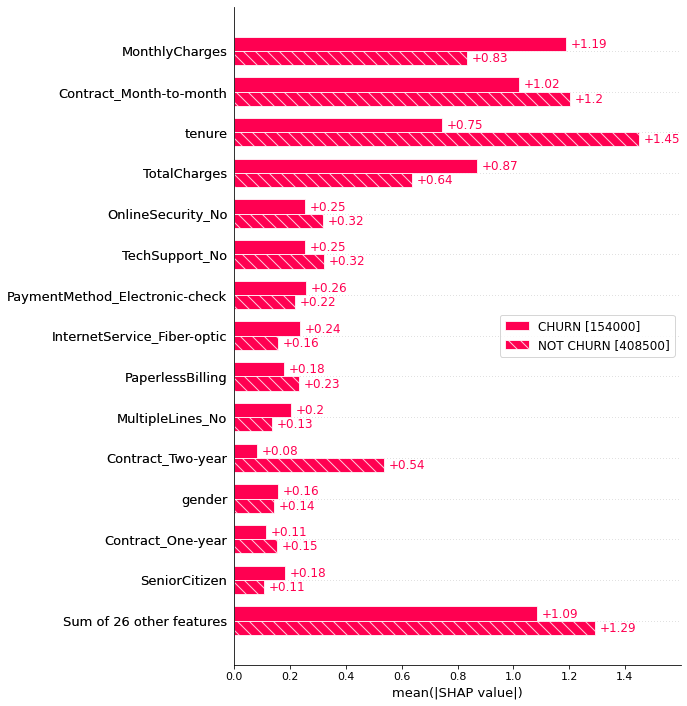

In [6]:
# Cohort plots: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html?#Cohort-bar-plot
churn_cohort = list(y_cmp.replace({1: 'CHURN', 0: 'NOT CHURN'})) # Used for splitting Explanation object
shap.plots.bar(shap_obj.cohorts(churn_cohort).abs.mean(0), max_display=15) # Show feature importance by cohorts

One-hot-encoding (OHE) was applied for compatibility with XGBoost data representations. The problem of interpreting a model composed of multiple OHE expanded columns becomes apparent since the hierarchy of contract duration was not explicitly modelled. For example, a contract that is not month-to-month can be one-year or two-year. Alternatively, we could have encoded the "Contract" column with ordinal encodings (e.g., 1, 12, 24 months) instead of having three separate OHE columns to represent this categorical feature. This would require creating a new model and running the explainable AI workflow again to so that feature impacts are rebalanced across the remaining features. There are pros and cons associated with both categorical encoding techniques. 

Perhaps we want to create cohort plots for non-binary features such as "Contract" as shown below. When expressed in terms of cohorts, the large impact of a two-year contract can be observed in the "Contract_Two-year" feature. Note that only the average magnitude of each feature is shown in the global feature importance plot. The phase and distribution of SHAP values are important to the explanation as well.

Model validation using explainable techniques enable us to look deeper into a model and apply our domain expertise to ensure that the model is well behaved. Experimentation is encouraged to help identify gaps in model understanding and develop new approaches for building a more predictive model. In turn, this may produce a more generalizable model we have more confidence in deploying. 

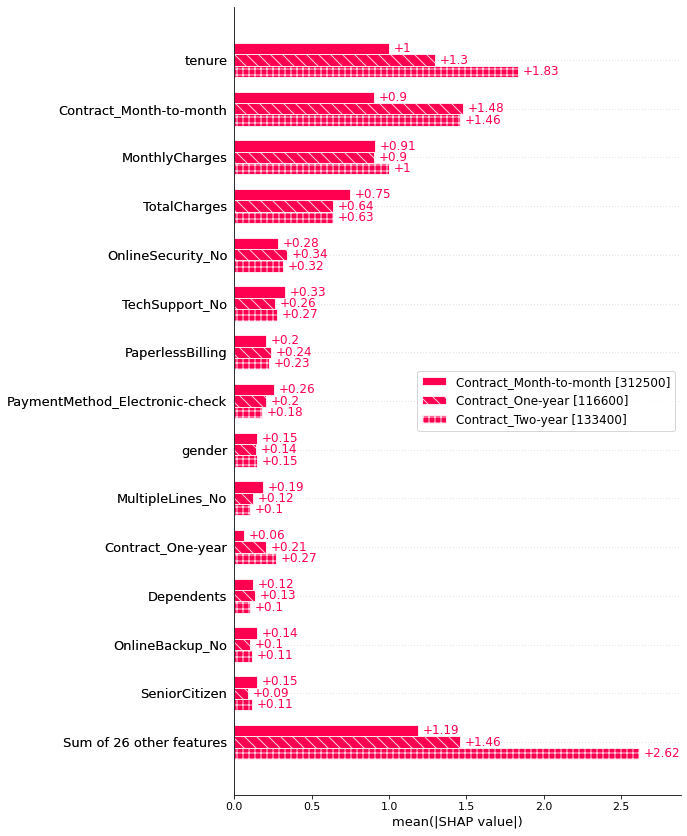

In [7]:
# List contract columns:
contract_cols = [cc for cc in X_cmp.columns if cc.startswith('Contract_')]

# Undo one-hot-encoding to obtain categorical classes from original "Contract" column:
contract_cohort = list(X_cmp[contract_cols].idxmax(axis=1))

# Plot cohorts:
shap.plots.bar(shap_obj.cohorts(contract_cohort).abs.mean(0), max_display=15)

The phase and distribution of SHAP values can be visualized via layered violin plots as shown below. Based on the stratification of high/low feature values, we can infer that: (1) long tenure accounts tend to exhibit less churn; (2) customers with month-to-month contracts are most likely to churn; (3) customers with high monthly charges are more likely to churn; etc. Since total charges are related to account tenure, accounts with high total charges tend to churn less often. The chart provides a convenient opportunity to check our intuition. However, univariate analysis is insufficient to draw conclusions or propose intervention strategies. Further visualizations using SHAP partial dependence plots may be required to gauge feature interactions. 

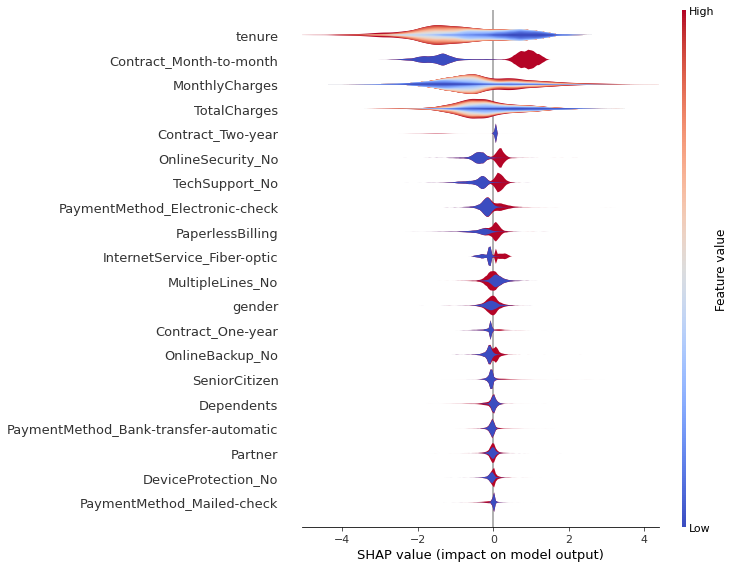

In [8]:
# Density plot for first row_trunc observations:
row_trunc = 100000 # Limit number of samples to plot
shap.summary_plot(shap_values[:row_trunc,:], features=X_cmp.iloc[:row_trunc,:], plot_type='layered_violin')

## SHAP Decision Plots

Decision plots help visualize how each factor influences the predicted outcome. One hundred samples from each churn class was selected to demonstrate the concept. Based on the results, we may observe that there are patterns within the data to suggest that within the churn class, there are sub-groups (or personas) that needs to be considered. Perhaps we want to create personas for customers who are likely to churn. Then we can test intervention strategies for customer retention tailored to each persona. Alternatively, we may also want to identify customers who may be receptive to adding additional services to their account if given an incentive (e.g., bundled services, discounts, rate locks, etc.). 

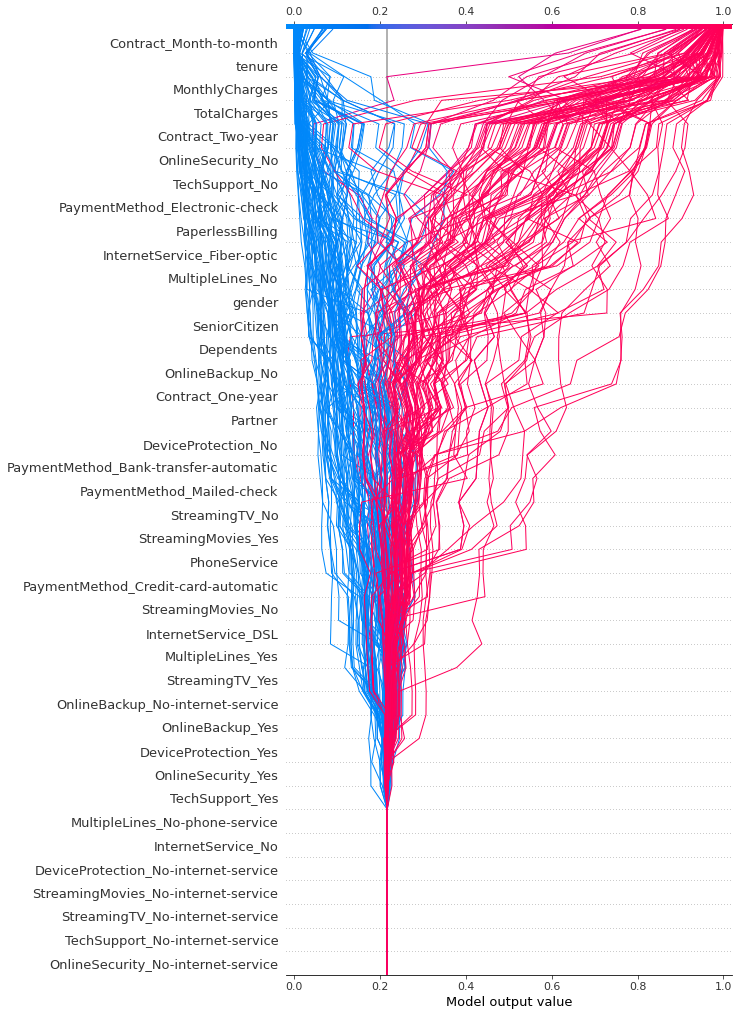

In [9]:
# Select N_display_samp from each labelled class for further visualization:
N_display_samp = 100

# Stratified sampling:
pd_enc_sample = pd_enc.groupby(label_col).head(N_display_samp)
display_samp_idx = pd_enc_sample.index

# SHAP decision plot: https://slundberg.github.io/shap/notebooks/plots/decision_plot.html
# link='logit' shows probabilities on top.
shap.decision_plot(shap_expected_values[0], shap_values[display_samp_idx,:], features=X_cmp.iloc[display_samp_idx,:], link='logit', 
                   feature_display_range=slice(None, None, -1))

## Feature Selection Using SHAP

According to the SHAP package documentation on https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html?#Using-feature-clustering:

    "When working with SHAP we recommend a more direct approach that measures feature redundancy through model loss comparisons. The shap.utils.hclust method can do this and build a hierarchical clustering of the feature by training XGBoost models to predict the outcome for each pair of input features. For typical tabular dataset this results in much more accurate measures of feature redundancy than you would get from unsupervised methods like correlation."

The shap.utils.hclust() method uses multi-threaded CPUs to build the individual XGBoost models. For illustration purposes, we can deduplicate the data to obtain ~7k records, then run it through the suggested clustering method to help with feature selection. If the technique works well, we may choose to implement a GPU accelerated version to scale to larger datasets.

No/low signal found from feature 6 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
41it [00:17,  1.10s/it]                                                                                          


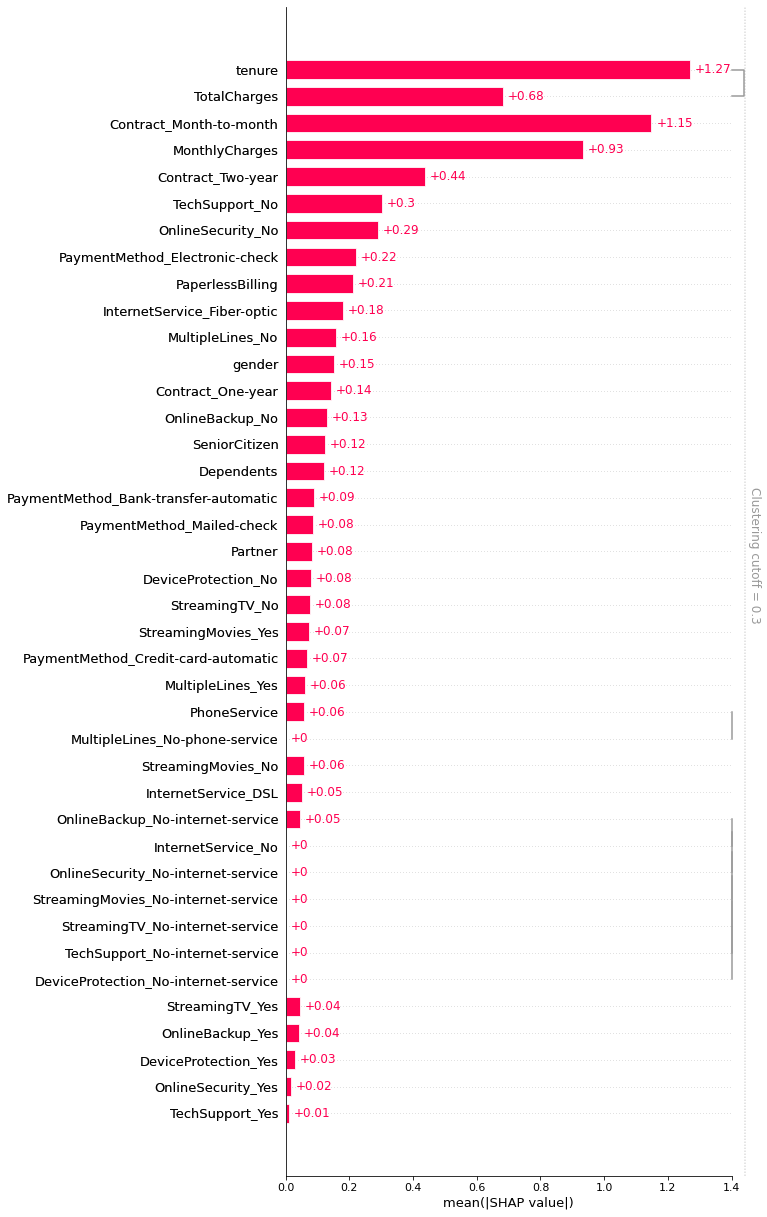

In [10]:
# Identify unique records from data. Recall that data was duplicated during data generation stage.
unique_idx = pd_enc.drop(columns='cv_idx').drop_duplicates().index.values

# Create explainer object to use with SHAP plotting methods:
explainer = shap.TreeExplainer(model, X_cmp.iloc[unique_idx])
shap_values_dedupe = explainer(X_cmp.iloc[:5]) # Compute for dummy data

# Update values with externally computed values:
shap_values_dedupe.data = X_cmp.iloc[unique_idx].values
shap_values_dedupe.values = shap_values[unique_idx]
shap_values_dedupe.base_values = shap_expected_values[unique_idx]

# Apply hierarchical clustering [computationally intensive step]. 
clustering = shap.utils.hclust(X_cmp.iloc[unique_idx], y_cmp.iloc[unique_idx]) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models

# Plot results:
shap.plots.bar(shap_values_dedupe, clustering=clustering, clustering_cutoff=0.3, max_display=40)

From SHAP feature clustering docs: 

    "Once we compute such a clustering we can then pass it to the bar plot so we can simultainously visualize both the feature redundancy structure and the feature importances. Note that by default we don’t show all of the clustering structure, but only the parts of the clustering with distance < 0.5. Distance in the clustering is assumed to be scaled roughly between 0 and 1, where 0 distance means the features perfectly redundant and 1 means they are completely independent."

In our case, the "_No-internet-service" suffix appear to be redundant at a cutoff threshold of 1% (i.e., 99% redundancy). We can select one member of the cluster (e.g., "InternetService_No") to represent the feature group and discard related features such as [OnlineSecurity_No-internet-service, OnlineBackup_No-internet-service, etc.]. From intuition, having a "True" value for "InternetService_No" requires that other "_No-internet-service" suffix fields also be "True" as well. This allows us to reduce the number of features by 6 without loss of generality. A new model needs to be trained on the reduced feature set, optimized, and validated once more. In general, we cannot assume that using an existing model and dropping features in post processing is sufficient. 

At a clustering cutoff of 30%, [MultipleLines_Yes, MultipleLines_No] and [tenure, TotalCharges] were identified as being similar feature sets. User judgement is necessary to determine if any members in the feature set can be dropped. We may also choose to drop features based on their feature importance (e.g., select top 20 independent features). Independent features are needed to represent the data in as few dimensions as possible. This is especially relevant when we want to identify causal relationships. 

## Feature Selection Using Correlation Plots

CPU times: user 5.09 s, sys: 194 ms, total: 5.29 s
Wall time: 5.03 s


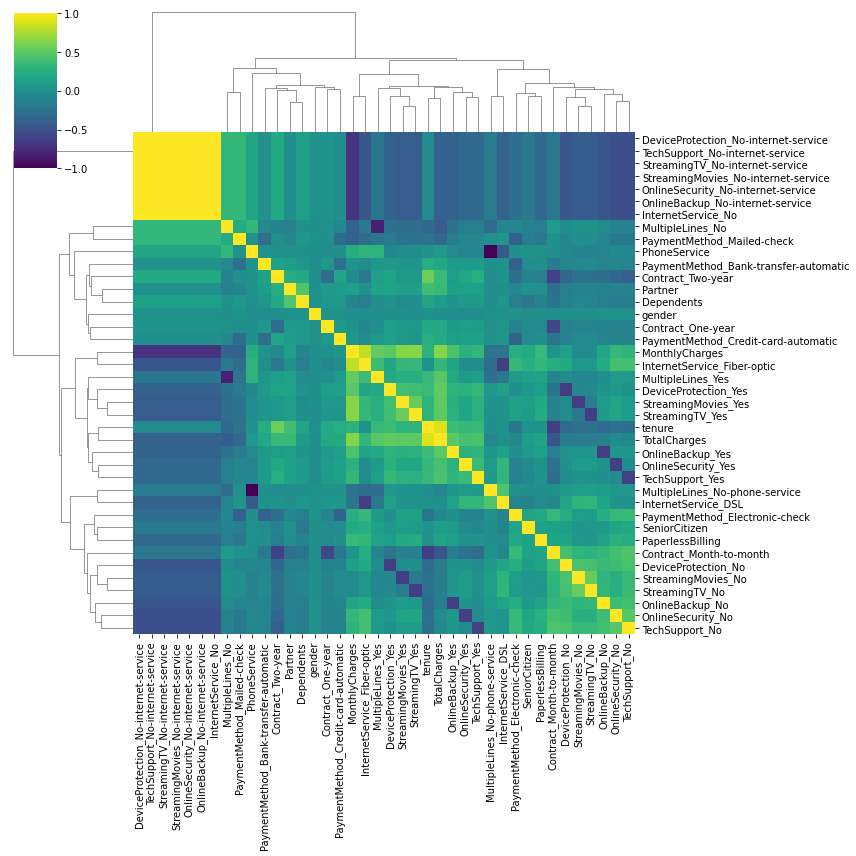

In [11]:
%%time
import seaborn as sns

# Use clustermap & dendrogram to determine independent features to select:
X_corr = X_cmp.corr(method='spearman')
sns.clustermap(X_corr, cmap='viridis', figsize=(12, 12))

The findings regarding feature similarity between "_No-internet-service" suffix attributes are also supported with a pairwise (Spearman) correlation clustermap. It is difficult to identify [MultipleLines_Yes, MultipleLines_No] as similar since they're not clustered together in the dendrogram (plotted along the margins). However, [tenure, TotalCharges] are well correlated as observed from the SHAP feature clustering. [StreamingMovies, StreamingTV] are very similar according to pairwise correlation but quite different when SHAP values are considered. 

# Summary

It is often advantageous to look at data from multiple different perspectives. Methods which may have been too computationally intensive to run previously may now become an option with GPU acceleration and distributed computing. SHAP values provide a firmer foundation for simultaneously selecting features based on importance and independence using the techniques implemented in shap.utils.hclust(). Once the computationally expensive task of computing SHAP values is accomplished, we can apply standard techniques (e.g., feature engineering, dimensional reduction, clustering, etc.) to examine the data representation within the transformed space. The insights gained can be used to build a more robust and generalized model which can also provide justification for its predictions.